In [2]:
import numpy as np
import random
from matplotlib import pyplot as plt, cm, colors
import matplotlib.pyplot as plt
from scipy.stats import multivariate_normal
import pandas as pd 
from itertools import chain
import itertools
from __future__ import absolute_import, division, print_function
import tensorflow as tf
from sklearn.model_selection import train_test_split
from operator import itemgetter
tf.autograph.set_verbosity(0)
from tqdm import tqdm
import os
from mpl_toolkits.mplot3d import Axes3D
from scipy.interpolate import griddata
from scipy.interpolate import bisplrep, bisplev
from scipy.ndimage import gaussian_filter
from collections import namedtuple
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import log_loss
from itertools import compress

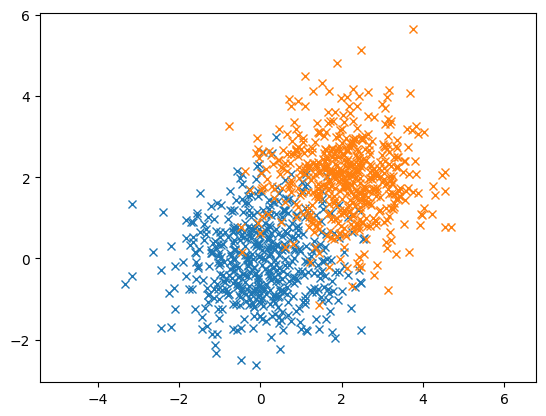

,X1,X2,Label
0,-0.001461,-0.657357,1
1,1.649351,1.996010,0
2,0.480067,-2.240576,1
3,0.768943,1.624317,0
4,-0.048678,-0.573525,1


In [3]:
random.seed(2349324)
np.random.seed(2349324)
tf.random.set_seed(2349324)

n = 1000
mean = [0,0]
covmat = [[1, 0], [0, 1]]
cov  = covmat   
x1_1, x2_1 = np.random.multivariate_normal(mean, cov, int(n/2)).T
 
mean = [2,2]
cov  = covmat   
x1_2, x2_2 = np.random.multivariate_normal(mean, cov, int(n/2)).T


plt.plot(x1_1, x2_1, 'x')
plt.plot(x1_2, x2_2, 'x')
plt.axis('equal')
plt.show()

pts1 = list(zip(x1_1, x2_1,itertools.repeat(1)))
pts2 = list(zip(x1_2, x2_2,itertools.repeat(0)))



first_second = pd.DataFrame(np.concatenate((pts1,pts2),axis=0), columns = ["X1", "X2", "Label"])
second_first = pd.DataFrame(np.concatenate((pts2,pts1),axis=0), columns = ["X1", "X2", "Label"])
interleaved  = pd.DataFrame([x for t in zip(pts1, pts2) for x in t], columns = ["X1", "X2", "Label"])

interleaved.head()



In [4]:
##TODO-CODE
#DONE Build model
#DONE Split
#DONE Train model (UNREDUCED )
#DONE Leave One Out
#DONE Print Scatterplot
#-----------------
##TODO-EXP
# Individual
#DONE    - Absolute
#DONE    - Negative
#DONE    - Positive

# Group
#   - Absolute




In [5]:
def split(df):
  x = df[['X1','X2']]
  y = df['Label']
  Data = namedtuple('Data', ['x_train','x_test','y_train','y_test'])
  x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=2349324)
  return Data(x_train = x_train,x_test=x_test,y_train = y_train,y_test=y_test)


def binary_cross_entropy(predictions, probabilities):
    binary_crossentropy = []
    for i in range(len(predictions)):
        b = predictions[i]
        p = probabilities[i][1]  # Assuming the probability of the positive class is at index 1

        # Calculate the binary crossentropy
        cross_entropy = -b * np.log(p) - (1 - b) * np.log(1 - p)
        binary_crossentropy.append(cross_entropy)

    return binary_crossentropy

    

def train_predict(data):

    np.random.seed(2349324)

  
    fan_avg = (data.x_train.shape[1] + 1) / 2  # Average of input and output dimensions
    limit = np.sqrt(6 / fan_avg)
    weights_init = np.random.uniform(low=-limit, high=limit, size=(data.x_train.shape[1],))

    logreg = LogisticRegression(solver='liblinear', random_state=2349324)
    logreg.coef_ = weights_init.reshape(1, -1)


    logreg.fit(data.x_train, data.y_train)

    y_pred  = logreg.predict(data.x_test)
    y_proba = logreg.predict_proba(data.x_test)

    return binary_cross_entropy(list(data.y_test), y_proba)

  


def leave_one_out(df, inf_type="individual", n=1):
   
    loo_dfs = []
    if inf_type=='individual':
        for i in df.index:
            loo_dfs.append((i,df.drop([i])))
        
    if inf_type=='group':
        for i in df.index:
            datapoints_to_remove = (random.sample(range(0, max(df.index)), n))
            loo_dfs.append((datapoints_to_remove,df.drop(datapoints_to_remove)))
    
    return loo_dfs
 

def remove_element_by_index(lst, index):
    return lst[:index] + lst[index+1:]



def run(df):
    
    full_loss = train_predict(split(df))
    indexes = []
    influences = []
    datasets = leave_one_out(df)
    
    for ds in tqdm(datasets):
        data = split(ds[1])
        loss = train_predict(data)
        influence_array= np.array(loss)-np.array(full_loss)
        indexes.append(ds[0])
        influences.append(influence_array)

    return list(zip(indexes,influences))


def run_group(df, n):
    full_loss = train_predict(split(df))
    indexes = []
    influences = []
    datasets = leave_one_out(df, inf_type='group',n=n)
    
    for ds in tqdm(datasets):
        data = split(ds[1])
        loss = train_predict(data)
        influence_array= np.array(loss)-np.array(full_loss)
        indexes.append(ds[0])
        influences.append(influence_array)

    return list(zip(indexes,influences))
    


def aggregate(df,lst, aggreg_type):

        indexes = [x[0] for x in lst]
        inf_array = []
        influences = []
 
        for tup in lst:
            inf_array.append(tup[1])

        if aggreg_type =='mean':
            influences = [np.mean(x) for x in inf_array]

        elif aggreg_type =='absolute':
            influences = [np.mean(np.absolute(x)) for x in inf_array]

        elif aggreg_type =='sum':
            influences = [np.sum(x) for x in inf_array] 

        elif aggreg_type =='absolute_sum':
            influences = [np.sum(np.absolute(x)) for x in inf_array]

        elif aggreg_type =='positive':
      
            for i in inf_array:
                filter = np.array(i) > 0
                filtered_arr = np.array(i)[filter]
                influences.append(np.mean(filtered_arr))

        elif aggreg_type =='negative':
      
            for i in inf_array:
                filter = np.array(i) < 0
                filtered_arr = np.array(i)[filter]
                influences.append(np.mean(filtered_arr))
       
       
        return pd.DataFrame(influences, index=indexes, columns=['Influence']).join(df)




def group_aggregate(lst, aggreg_type):
    points = [x[0] for x in lst]
    inf_array = []
    influences = []
    for i in lst:
        inf_array.append(i[1])

    if aggreg_type == 'mean':
        influences = [np.mean(x) for x in inf_array]


    elif aggreg_type == 'absolute':
        influences = [np.mean(np.absolute(x)) for x in inf_array]

    return pd.DataFrame(list(zip(points,influences)), columns=['Points','Influence'])

    







def create_scatter_plot(dataframe, x_col, y_col,title):
    plt.scatter(dataframe[x_col], dataframe[y_col])
    plt.xlabel(x_col)
    plt.ylabel(y_col)
    plt.title(title)
    plt.show()



def get_sum(individual_run, group_run):
    influences_added = []
    for point_set in group_run.Points:
        conjoint_influence = 0
        for point in point_set:
            conjoint_influence += individual_run.iloc[point].Influence
        influences_added.append(conjoint_influence)
    group_run['Sum'] = influences_added
    return group_run




In [6]:


exp_run = (run(interleaved))
abso_run = aggregate(interleaved,exp_run,'absolute')

def scatter_sorted_by_influence(dataframe, title):
    plt.figure(figsize=(6, 4))

    # Sort the data based on influence values
    sorted_indices = dataframe['Influence'].argsort()
    x_sorted = dataframe['X1'][sorted_indices]
    y_sorted = dataframe['X2'][sorted_indices]
    z_sorted = dataframe['Influence'][sorted_indices]

    # Plot the scatter plot with points sorted by influence values
    plt.scatter(x_sorted, y_sorted, s=12, c=z_sorted, cmap='jet')
    plt.title(title)
    plt.colorbar()
    plt.show()







100%|██████████| 1000/1000 [00:10<00:00, 93.46it/s]


In [7]:
def info(dataframe, title):
    fig = plt.figure(figsize=(15,6))
    ax1 = fig.add_subplot(121)
    ax2 = fig.add_subplot(122, projection='3d')
    
  
    x = dataframe['X1']
    y = dataframe['X2']
    z = dataframe['Influence']

     # Plot 2: Scatter Plot

     
    sorted_indices = z.argsort()
    x_sorted = x[sorted_indices]
    y_sorted = y[sorted_indices]
    z_sorted = z[sorted_indices]

    scatter = ax1.scatter(x_sorted, y_sorted, s=10, c=z_sorted, cmap='jet')
    ax1.set_xlabel('X1')
    ax1.set_ylabel('X2')
    ax1.set_title('Scatter Plot')
    fig.colorbar(scatter, ax=ax1, label='Influence')


    # Plot 2: 3D Scatter Plot

    scatter = ax2.scatter3D(x, y, z, c=z, cmap='jet')
    ax2.set_xlabel('X1')
    ax2.set_ylabel('X2')
    ax2.set_title('3D Scatter Plot')
    fig.colorbar(scatter, ax=ax2, label='Influence')
    ax2.invert_xaxis()
    ax2.invert_yaxis()

    # Adjust spacing and display the plots
    fig.suptitle(title)
    ax2.view_init(elev=30, azim=90)
    plt.show()









In [8]:
import pandas as pd
import matplotlib.pyplot as plt

def plot_correlation(dataframe, x_col, y_col, plot_title):
    """
    Plot a scatter plot with a 45-degree line and display the correlation coefficient.

    Args:
        dataframe (pandas.DataFrame): Input DataFrame.
        x_col (str): Name of the first column.
        y_col (str): Name of the second column.
    """
    x = dataframe[x_col]
    y = dataframe[y_col]

    # Calculate correlation coefficient
    correlation = dataframe[x_col].corr(dataframe[y_col])

    # Create scatter plot
    plt.scatter(x, y)
    plt.xlabel(x_col)
    plt.ylabel(y_col)
    plt.title(plot_title +' (Correlation: ' + str(round(correlation,2)) + ')')

    # Add 45-degree line
    min_val = min(min(x), min(y))
    max_val = max(max(x), max(y))
    plt.plot([min_val, max_val], [min_val, max_val], color='red', linestyle='--')

    plt.show()



In [ ]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import time

def density_plots(df, filled=True, title='Comparison of KDE Plots'):
    x = df['X1']
    y = df['X2']
    weights = df['Influence']


    # Create a figure with subplots
    fig, axs = plt.subplots(1, 2, figsize=(11, 6))

    # Subplot 1: Original KDE plot
    axs[0].set_title('Original Point Density')
    sns.kdeplot(x=x, y=y, cmap="gnuplot2", fill=filled, ax=axs[0])

    # Subplot 2: KDE plot with repeated data
    axs[1].set_title('Influence Density')
    scaling_factor = 1000
    repetitions = np.round(weights * scaling_factor).astype(int)

    x_repeated = np.repeat(x, repetitions)
    y_repeated = np.repeat(y, repetitions)
    sns.kdeplot(x=x_repeated, y=y_repeated, cmap="gnuplot2", fill=filled, ax=axs[1])



    # Adjust spacing between subplots
    fig.suptitle(title, fontsize=14, fontweight='bold')

    plt.tight_layout()


    # Show the plot
plt.show()


density_plots(abso_run, filled=False, title='Marginal Influence Train-To-Test')